<a href="https://colab.research.google.com/github/goodu001/ULD_prediction/blob/main/ULD_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Read the CSV file from Google Drive
# Use on_bad_lines='skip' with pd.read_csv
df = pd.read_csv('/content/drive/MyDrive/flight_prediction_dataset.csv', on_bad_lines='skip')

def parse_uld_details(uld_str):
    if pd.isna(uld_str):
        return {}
    uld_items = re.findall(r'([A-Z0-9]+)×(\d+)', uld_str)
    return {uld_type: int(count) for uld_type, count in uld_items}

uld_expanded = df['ULD_Details'].apply(parse_uld_details)
uld_df = pd.json_normalize(uld_expanded)
df_parsed = pd.concat([df.drop(columns='ULD_Details'), uld_df], axis=1)
df_parsed.fillna(0, inplace=True)

display(df_parsed.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,FlightID,FlightNumber,Date_Local,Departure_Local,Arrival_Local,Date_UTC,Departure_UTC,Arrival_UTC,Origin,Destination,Aircraft,Total_ULDs,Status,AKE,P1P,RKN,PMC,AMJ
0,1000,RG559,2025-01-18,7:30,15:15,2025-01-18,1:30,8:15,SIN,DXB,B737,29,Cancelled,17.0,12.0,0.0,0.0,0.0
1,1001,RG891,2025-06-16,8:15,11:15,2025-06-16,1:15,2:15,SYD,LAX,B787,9,Cancelled,0.0,0.0,9.0,0.0,0.0
2,1002,RG967,2025-06-06,9:45,14:45,2025-06-06,2:45,8:45,SIN,LHR,A380,15,Delayed,12.0,0.0,3.0,0.0,0.0
3,1003,RG611,2025-03-16,9:15,22:30,2025-03-16,1:15,15:30,HND,JFK,A350,1,Arrived,0.0,0.0,0.0,1.0,0.0
4,1004,RG569,2025-05-27,11:45,2:00,2025-05-27,5:45,20:00,CDG,LAX,A380,27,Arrived,0.0,5.0,0.0,19.0,3.0


In [ ]:
# Import necessary libraries for data manipulation, machine learning model, and evaluation metrics.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression # Import LinearRegression

# Filter out rows where 'Total_ULDs' cannot be converted to a number and convert the column to integer type.
df_parsed = df_parsed[pd.to_numeric(df_parsed['Total_ULDs'], errors='coerce').notnull()]
df_parsed['Total_ULDs'] = df_parsed['Total_ULDs'].astype(int)

# Convert categorical columns ('Aircraft', 'Origin', 'Destination') to string type to ensure consistency for encoding.
df_parsed['Aircraft'] = df_parsed['Aircraft'].astype(str)
df_parsed['Origin'] = df_parsed['Origin'].astype(str)
df_parsed['Destination'] = df_parsed['Destination'].astype(str)

# Define the features to be used for training the model, including categorical and ULD type columns.
features = ['Aircraft', 'Origin', 'Destination'] + uld_df.columns.tolist()
X = df_parsed[features]
# Define the target variable, which is 'Total_ULDs'.
y = df_parsed['Total_ULDs']

# Create a ColumnTransformer to apply OneHotEncoder to the categorical features and pass through the rest.
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Aircraft', 'Origin', 'Destination'])
], remainder='passthrough')

# Create a machine learning pipeline that first preprocesses the data and then applies a LinearRegression model.
model = Pipeline([
    ('prep', preprocessor),
    ('reg', LinearRegression()) # Changed to LinearRegression
])

# Split the data into training and testing sets for model training and evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train the model using the training data.
model.fit(X_train, y_train)

# Make predictions on the test data.
y_pred = model.predict(X_test)
# Calculate and print the Root Mean Squared Error (RMSE) to evaluate the model's prediction accuracy.
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
# Calculate and print the R-squared score to evaluate how well the model fits the data.
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 3.26857294849089e-05
R² Score: 0.9999999999917303


# Data Processing and Model Training Overview

## Import Libraries
- Imports necessary libraries from scikit-learn for:
  - Data splitting
  - Model creation
  - Preprocessing
  - Evaluation
- Imports numpy for numerical operations and specifically imports `LinearRegression`.

## Data Cleaning and Preparation
- Filters out rows where `Total_ULDs` cannot be converted to a number and converts the column to an integer type.
- Converts the `Aircraft`, `Origin`, and `Destination` columns to string type to ensure consistency before encoding.

## Define Features and Target
- Defines the list of features (`features`) for training, including:
  - Categorical columns: `Aircraft`, `Origin`, `Destination`
  - Columns representing counts of different ULD types (from `uld_df` DataFrame).
- Defines the target variable (`y`) as the `Total_ULDs` column.

## Create Preprocessing Pipeline
- Uses `ColumnTransformer` to apply different preprocessing steps to different columns:
  - Applies `OneHotEncoder` to categorical features (`Aircraft`, `Origin`, `Destination`) to convert them into a numerical format.
    - `handle_unknown='ignore'` is used to manage unseen categories during prediction.
  - `remainder='passthrough'` ensures other columns (ULD type counts) are passed through without transformation.

## Create Machine Learning Pipeline
- Creates a `Pipeline` that combines the preprocessing step (`preprocessor`) and the machine learning model (`LinearRegression`).
- Ensures consistent application of preprocessing steps to both training and testing data.

## Split Data
- Splits the data into training and testing sets using `train_test_split`:
  - 80% of the data is used for training (`X_train`, `y_train`).
  - 20% is used for testing (`X_test`, `y_test`).
  - `random_state=42` ensures consistent splits across runs.

## Train the Model
- Trains the `LinearRegression` model using the training data (`X_train`, `y_train`).
- The pipeline automatically applies preprocessing steps before training.

## Make Predictions
- Makes predictions on the test data (`X_test`) using the trained model.

## Evaluate the Model
- Calculates and prints the Root Mean Squared Error (RMSE) to measure the average difference between predicted and actual `Total_ULDs` values.
  - A lower RMSE indicates better accuracy.
- Calculates and prints the R-squared score, representing the proportion of variance in the target variable predictable from the features.
  - An R-squared score close to 1 indicates a good fit.

## Summary
This process takes the cleaned and transformed data, prepares it for a linear regression model, trains the model, and evaluates its performance using RMSE and R-squared.


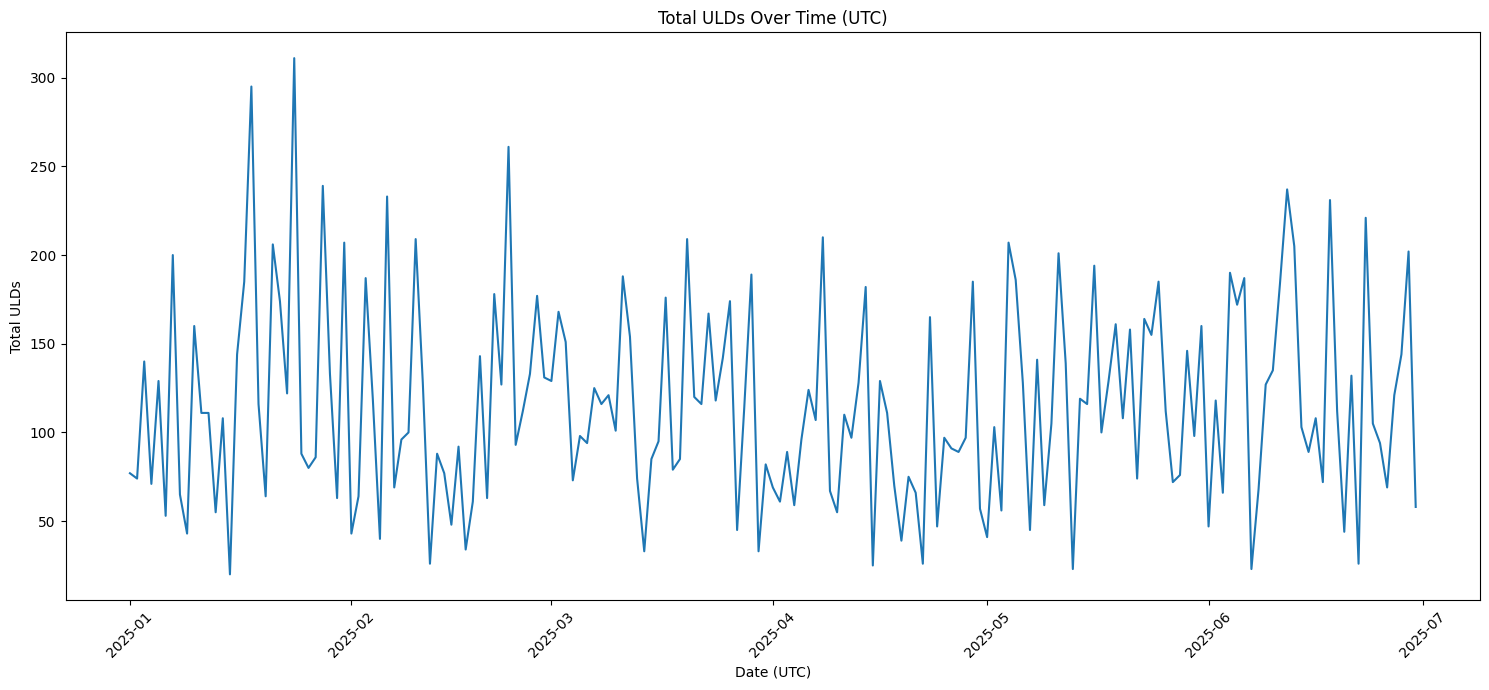

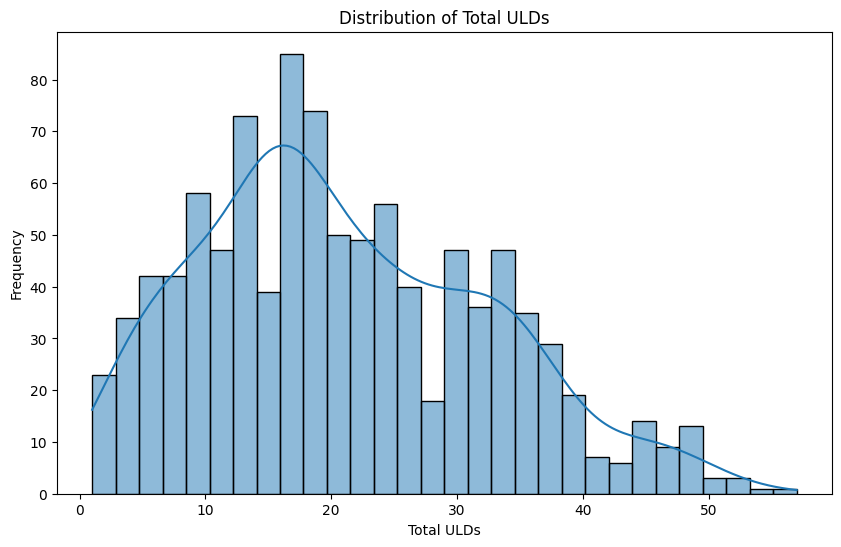

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Date_UTC' to datetime objects
df_parsed['Date_UTC'] = pd.to_datetime(df_parsed['Date_UTC'])

# Group by date and sum the Total_ULDs
daily_uld_counts = df_parsed.groupby('Date_UTC')['Total_ULDs'].sum().reset_index()

# Plot the total ULDs over time
plt.figure(figsize=(15, 7))
sns.lineplot(data=daily_uld_counts, x='Date_UTC', y='Total_ULDs')
plt.title('Total ULDs Over Time (UTC)')
plt.xlabel('Date (UTC)')
plt.ylabel('Total ULDs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additionally, let's look at the distribution of the total ULDs
plt.figure(figsize=(10, 6))
sns.histplot(df_parsed['Total_ULDs'], bins=30, kde=True)
plt.title('Distribution of Total ULDs')
plt.xlabel('Total ULDs')
plt.ylabel('Frequency')
plt.show()

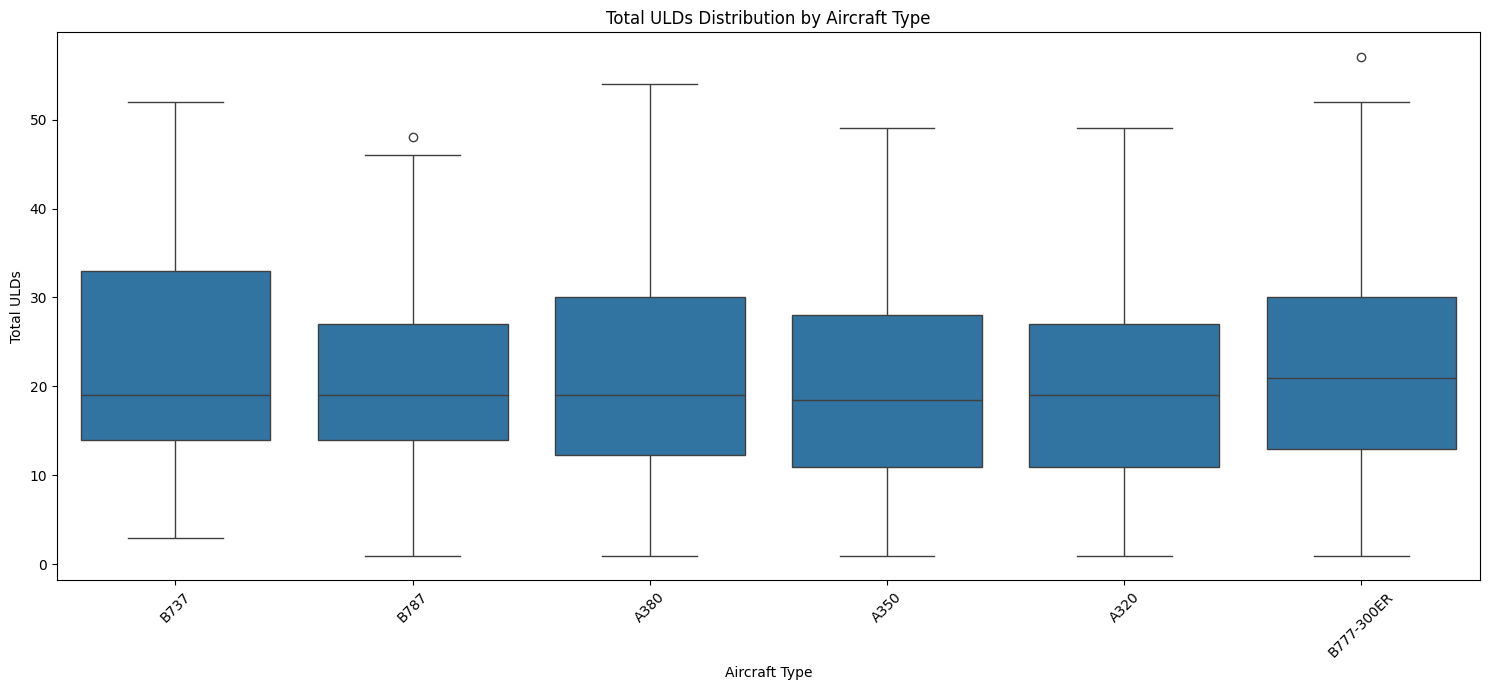

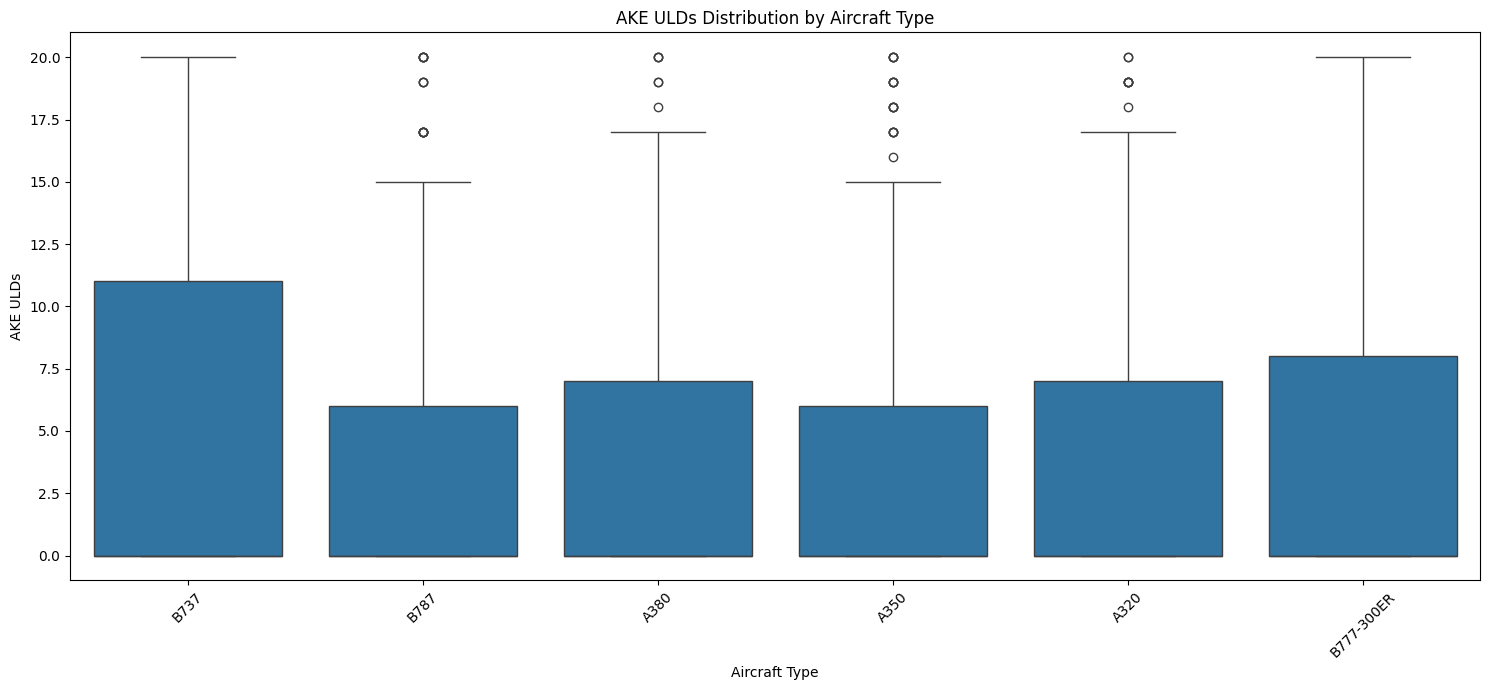

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the relationship between Aircraft and Total_ULDs
plt.figure(figsize=(15, 7))
sns.boxplot(data=df_parsed, x='Aircraft', y='Total_ULDs')
plt.title('Total ULDs Distribution by Aircraft Type')
plt.xlabel('Aircraft Type')
plt.ylabel('Total ULDs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the relationship between Aircraft and AKE ULDs
plt.figure(figsize=(15, 7))
sns.boxplot(data=df_parsed, x='Aircraft', y='AKE')
plt.title('AKE ULDs Distribution by Aircraft Type')
plt.xlabel('Aircraft Type')
plt.ylabel('AKE ULDs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()